# Laboratorio Faster-RCNN parte 1

Alumno: Ariel Carvajal

## Dependendencias y utilidades

Para este laboratorio, debemos importar las siguientes librerias que nos permitiran utilizar Faster RCNN sin que debamos entrar a programar los modelos y utilidades nosotros mismos.

In [1]:
import gc

import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import nms
import torchvision.transforms as T

import cv2
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
from tqdm import tqdm
import math
import pandas as pd
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Modelo preentrenado

Faster RCNN es un modelo de deteccion de objetos bastante famoso debido a su rapidez de inferencia y a su buen rendimiento. Debido a esto, pytorch, y en particular torchvision, nos provee ya con una implementacion de este modelo (y muchos otros!) listo para usar. Esta la podemos encontrar aqui: https://pytorch.org/docs/stable/torchvision/models.html

En particular, para tener acceso al modelo de Faster RCNN que nos ofrece pytorch, la linea que hace esto es la siguiente:


```
from torchvision.models.detection import fasterrcnn_resnet50_fpn
```


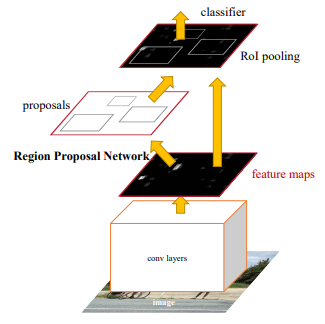

In [2]:
# Aqui importamos la implementacion que nos ofrece torchvision de faster RCNN.
# En particular, la implementacion presente en torchvision utiliza ResNet-50-FPN como backbone. 
# Que es backbone? En deeplearning se le llama backbone a la red utilizada para 
# extraer los features que posteriormente son usados en la posterior seccion del modelo. 

frcnn_model = fasterrcnn_resnet50_fpn(pretrained=True, progress=True, num_classes=91, pretrained_backbone=True, trainable_backbone_layers=3) #Instanciamos el modelo

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

**La clase fasterrcnn_resnet50_fpn tiene los siguientes parametros:**

**pretrained** (bool): True si quieremos utilizar la red con los pesos preentrenados en el dataset COCO train2017.

**progress** (bool): En caso de que queramos utilizar los pesos preentrenados, si queremos mostrar un display de cuanto tardara la descarga de estos.

**pretrained_backbone** (bool): Si queremos que el backbone este preentrenado en el dataset Imagenet. Este parametro solo interesa si definimos pretrained=False.

**num_classes** (int): Cuantas clases o categorias de objetos queremos poder detectar. Este numero debe incluir el fondo, por lo que si queremos utilizarlo para detectar perros y gatos, este parametro debe valer 3.

**trainable_backbone_layers** (int): Cuantos de los bloques residuales de la resnet queremos que sean entrenables comenzando desde el bloque mas profundo hasta el inicio de la red. Resnet50 tiene 5 bloques, por lo que este int va entre 0 (si no queremos entrenar ningun bloque) y 5 (si queremos entrenarlos todos).

## Analisis del modelo

Ya que sabemos instanciar Faster RCNN, imprimamos en pantalla sus secciones para tener una mejor comprension de él tal como se vio en la clase teorica.

In [3]:
#Para imprimir las componentes de un modelo en pytorch, basta con hacerle un print.
print(frcnn_model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Wow, tiene muchas secciones! 
Veamos por encima que es cada una.

### Transform

```
(transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
```






Transform se encarga de aplicarle una transformada, o preprocesamiento, a toda imagen que entre al modelo. Este procesamiento consiste en normalizar la imagen:
```
image = (image - mean) / std
```

Y hacerle un resize de tal manera que ningun lado de la imagen tenga un tamano menor a min size o mayor a max size, y en caso de necesitar hacer un resize, que interpolacion usar.

### Backbone

```
(backbone): BackboneWithFPN
```
Una vez preprocesada la imagen de entrada, esta pasa al backbone, el cual consiste en una Resnet50 con Feature Pyramid Networks. 

En la primera parte del backbone podemos ver la Resnet50, tal como la vieron en la clase anterior de modelos para clasificacion. Esta Resnet se compone de una capa inicial con una convolucional, seguida por un bacthnormalization, relu y max pooling, y luego 4 capas con distintos numeros de bottlenecks.

```
(body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
        )
      )
      (layer2): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): FrozenBatchNorm2d(512)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512)
          (relu): ReLU(inplace=True)
        )
        (3): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512)
          (relu): ReLU(inplace=True)
        )
      )
      (layer3): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(256)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(256)
          (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(1024)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): FrozenBatchNorm2d(1024)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(256)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(256)
          (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(1024)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(256)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(256)
          (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(1024)
          (relu): ReLU(inplace=True)
        )
        (3): Bottleneck(
          (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(256)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(256)
          (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(1024)
          (relu): ReLU(inplace=True)
        )
        (4): Bottleneck(
          (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(256)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(256)
          (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(1024)
          (relu): ReLU(inplace=True)
        )
        (5): Bottleneck(
          (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(256)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(256)
          (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(1024)
          (relu): ReLU(inplace=True)
        )
      )
      (layer4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(512)
          (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(512)
          (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(2048)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): FrozenBatchNorm2d(2048)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(512)
          (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(512)
          (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(2048)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(512)
          (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(512)
          (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(2048)
          (relu): ReLU(inplace=True)
        )
      )
    )
```

En el backbone, aparte de la resnet50 que ustedes ya conocen, existe un componente extra, una Feature Pyramid Network (FPN) que es la siguiente:
```
(fpn): FeaturePyramidNetwork(
      (inner_blocks): ModuleList(
        (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
        (3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (layer_blocks): ModuleList(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (extra_blocks): LastLevelMaxPool()
    )
```

Que es esto y para que sirve? Para cualquier red convolucional, a medida que avanzamos en las capas vamos ganando informacion semantica pero en paralelo vamos perdiendo resolucion. Esto significa que por ejemplo si tenemos objetos muy chicos en la imagen, es probable que estos se pierdan luego de un par de capas. Esto es muy malo para un detector, ya que nosotros queremos ser capaces de detectar un objeto sin importar si este es grande o chico en la imagen. 




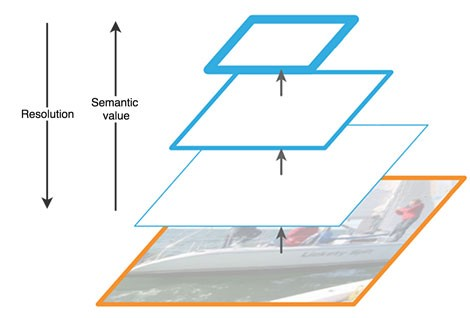

Las FPN lo que hacen es procesar los mapas de features ahora tambien de forma top-down para entregarle a las primeras capaz de la red, ricas en resolucion, la informacion rica en contenido semantico que tienen las ultimas capas.

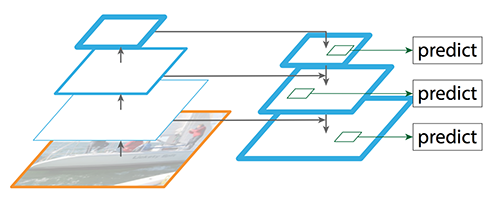

De  esta manera, pasamos de tener un backbone que nos entrega un feature map para una sola resolucion como este:

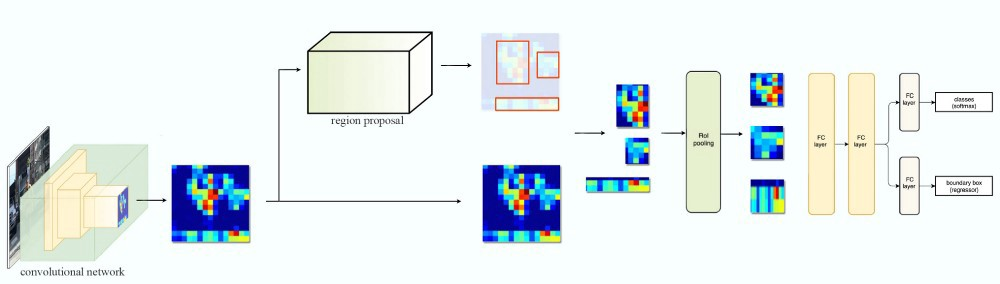

A tener un backbone que nos entrega el feature map a varias resoluciones:

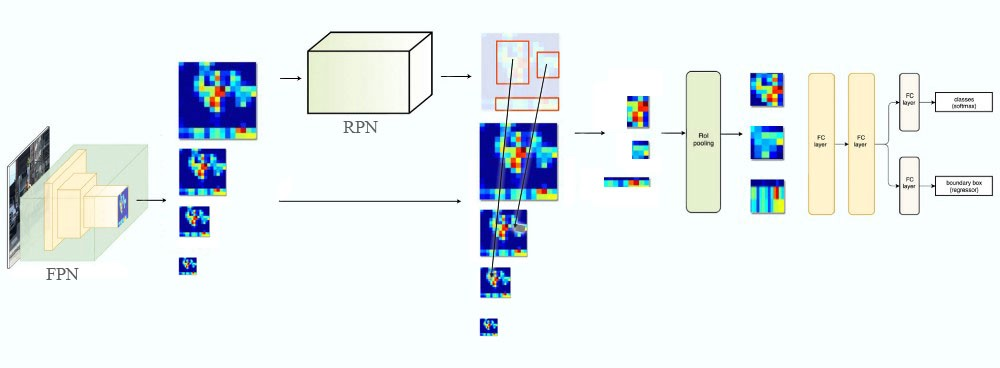

De esta forma, dependiendo luego de que tamaño sea el Region of Interest (ROI) generado en la componente RPN, recortamos este ROI del feature map con la resolucion mas util para este. Por ejemplo, si el ROI generado es chico, significa que que necesitamos utilizar el feature map de mayor resolucion para posteriormente poder clasificar este objeto. En cambio si el ROI es muy grande, nos conviene utilizar el feature map mas chico en resolucion.

### RPN

```
(rpn): RegionProposalNetwork(
    (anchor_generator): AnchorGenerator()
    (head): RPNHead(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
      (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
    )
  )
```

Esta es la seccion del modelo encargada de procesar el mapa de features que sale del backbone, para generar todas las regiones de interes (ROI) que posteriormente seran procesadas para clasificar el objeto que tienen dentro.

### ROI pooling y clasificacion

```
(roi_heads): RoIHeads(
    (box_roi_pool): MultiScaleRoIAlign()
    (box_head): TwoMLPHead(
      (fc6): Linear(in_features=12544, out_features=1024, bias=True)
      (fc7): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (box_predictor): FastRCNNPredictor(
      (cls_score): Linear(in_features=1024, out_features=91, bias=True)
      (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
    )
  )
```

La primera parte de esta componente, MultiScaleRoIAlign, se encarga de dejar todos nuestros RoI del mismo tamaño para que la puedan procesar las capas lineales -o densas- del TwoMLPHead. Posteriormente la salida del TwoMLPHead es procesada por una capa lineal (cls_score) que es la encargada de decirnos a que clase pertenece este ROI, y tambien por (bbox_pred), que es la capa densa encargada de darnos la regresion del bouding box que sirve para hacer las coordenadas del bouding box del objeto mas precisas.

## COCO 2017

Torchvision nos ofrece su implementacion de Faster RCNN ya preentrenado con un dataset de deteccion. Este dataset es COCO 2017.

COCO es un dataset liberado para deteccion, segmentacion y captioning de objetos. Este lo puden en el siguiente link: https://cocodataset.org/#home

COCO define 91 clases de objetos, pero de estas 91 clases los datos solo utilizan 80. Para poder ver cuales son las clases incluidas en COCO, podemos utilizar este link https://cocodataset.org/#explore, el cual nos muestra de forma interactiva las clases y ejemplos de estas en sus datos. Atentos que este visualizador nos muestra los objetos de forma segmentada, pero Faster RCNN utiliza la componente de bounding box de los datos.

COCO tiene un total de 118K imagenes y las clases que tiene son las siguientes.

In [4]:
# Como queremos utilizar Faster RCNN preentrenado sin ninguna modificacion, debemos
# entonces utilizar las mismas clases (y en el mismo orden) que COCO 2017. 
# Estas clases las definimos a continuacion.
CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


## Inferencia con Faster RCNN preentrenado

Ahora que tenemos nuestro modelo preentrenado listo y tambien cuales son las clases que este puede predecir, veamos que usarlo.

In [5]:
# Primero debemos indicarle al modelo que lo queremos usar solo para inferencia y no lo queremos entrenar.
# Esto lo hacemos de la siguiente forma
frcnn_model.eval()

#Tambien, si queremos aprovechar la GPU, debemos mover nuestro modelo a la GPU
frcnn_model = frcnn_model.to(device)

Definamos una funcion que reciba una imagen, y un score minimo (threshold), para detectar los objetos presentes en ella y retornar todos los que tengan un score superior a este threshold.

In [6]:
def get_prediction(img_path, threshold):
  #img_path: La direccion de la imagen a procesar
  #threshold: Score minimo que debe tener el objeto detectado para considerarlo

  img = T.ToTensor()(Image.open(img_path)).to(device) # Convertimos la imagen a un tensor y la llevamos al device (GPU)
  pred = frcnn_model([img]) # Pasamos la imagen al modelo para obtener la prediccion

  #El modelo funciona de la siguiente forma, este recibe como entrada una lista de imagenes en forma de tensores,
  # y retorna una variable prediccion. Esta prediccion es una lista de todas las predicciones para cada imagen 
  # que se le paso en la entrada al modelo. En nuestro caso solo le estamos danto una imagen de entrada,
  # por lo que solo nos interesa pred[0]. Si le pasaramos X imagenes, nos interesaria desde pred[0] hasta pred[X-1].
  
  #Cada prediccion ademas corresponde a un diccionario que tiene los siguientes 3 items.
  # 'boxes': Tiene las coordenadas x_min, y_min, x_max, y_max de todos los objetos predichos
  # 'labels': Es una lista de la clase a la que corresponde cada objeto detectado.
  # 'boxes': Tiene la coordenada de la esquina superior izquierda e inferior derecha de cada objeto detectado.
  # 'scores': Tiene el score (de 0 a 1) de que tan seguro esta el modelo de que esto sea de verdad un objeto.

  pred_class = [CATEGORY_NAMES[i] for i in list(pred[0]['labels'].detach().cpu().numpy())] # Convertimos el numero de la clase predicha al nombre de la clase
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())] # Obtenemos los BBs de todos los objetos predichos
  pred_score = list(pred[0]['scores'].detach().cpu().numpy()) #Obtenemos el score de todos los objetos
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold] # Filtramos de nuestras predicciones todos los objetos con un score menor a nuestro threshold
  if len(pred_t) > 0:
    pred_t = pred_t[-1]
  else:
    pred_t = -1
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  pred_score = pred_score[:pred_t+1]
  return pred_boxes, pred_class, pred_score #Retornamos el bounding box, la clase y el score de aquellos obetos que tuvieron mas score que el threshold

Definamos ahora una API que a partir de una imagen y su threshold, prediga los objetos detectados y nos muestre estos sobre la imagen original.

In [7]:
def object_detection_api(img_path, threshold=0.5, rect_th=1, text_size=0.5, text_th=2):
  #img_path: La direccion de la imagen a procesar
  #threshold: Score minimo que debe tener el objeto detectado para considerarlo
  #rect_th: Que tan ancho queremos dibujar los rectangulos
  #text_size: De que tamano quremos el texto
  #text_th: De que grosor queremos el texto

  boxes, pred_cls, pred_scrs = get_prediction(img_path, threshold) # Obtenemos las predicciones
  img = cv2.imread(img_path) # Volvemos a leer la imagen pero ahora con cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convertimos la imagen a RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Dibujamos un rectangulo de acuerdo a los BBs predichos
    cv2.putText(img,pred_cls[i]+':'+"{:.2f}".format(pred_scrs[i]), boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Escribimos a que clase pertenece cada BB
  plt.figure(figsize=(20,30)) # Mostramos la imagen
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()


In [8]:
#Descargamos algunas imagenes que contengan clases de COCO 2017 para probar el modelo

!wget https://cms.qz.com/wp-content/uploads/2019/02/zebras-e1550768121954.jpg -O zebras.jpg

!wget https://mundoenlinea.cl/wp-content/uploads/2019/11/Teletrabajo-678x381.jpg -O ofice.jpg

!wget https://2rdnmg1qbg403gumla1v9i2h-wpengine.netdna-ssl.com/wp-content/uploads/sites/3/2018/11/fastFoodEatOften-950649808-650x450-650x428.jpg -O eating.jpg

--2021-11-05 16:21:31--  https://cms.qz.com/wp-content/uploads/2019/02/zebras-e1550768121954.jpg
Resolving cms.qz.com (cms.qz.com)... 192.0.66.2
Connecting to cms.qz.com (cms.qz.com)|192.0.66.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 493943 (482K) [image/jpeg]
Saving to: ‘zebras.jpg’

zebras.jpg          100%[===================>] 482.37K  --.-KB/s    in 0.1s    

2021-11-05 16:21:31 (4.02 MB/s) - ‘zebras.jpg’ saved [493943/493943]

--2021-11-05 16:21:31--  https://mundoenlinea.cl/wp-content/uploads/2019/11/Teletrabajo-678x381.jpg
Resolving mundoenlinea.cl (mundoenlinea.cl)... 162.241.60.14
Connecting to mundoenlinea.cl (mundoenlinea.cl)|162.241.60.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63046 (62K) [image/jpeg]
Saving to: ‘ofice.jpg’

ofice.jpg           100%[===================>]  61.57K  --.-KB/s    in 0.07s   

2021-11-05 16:21:32 (945 KB/s) - ‘ofice.jpg’ saved [63046/63046]

--2021-11-05 16:21:32--  https://2rd

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


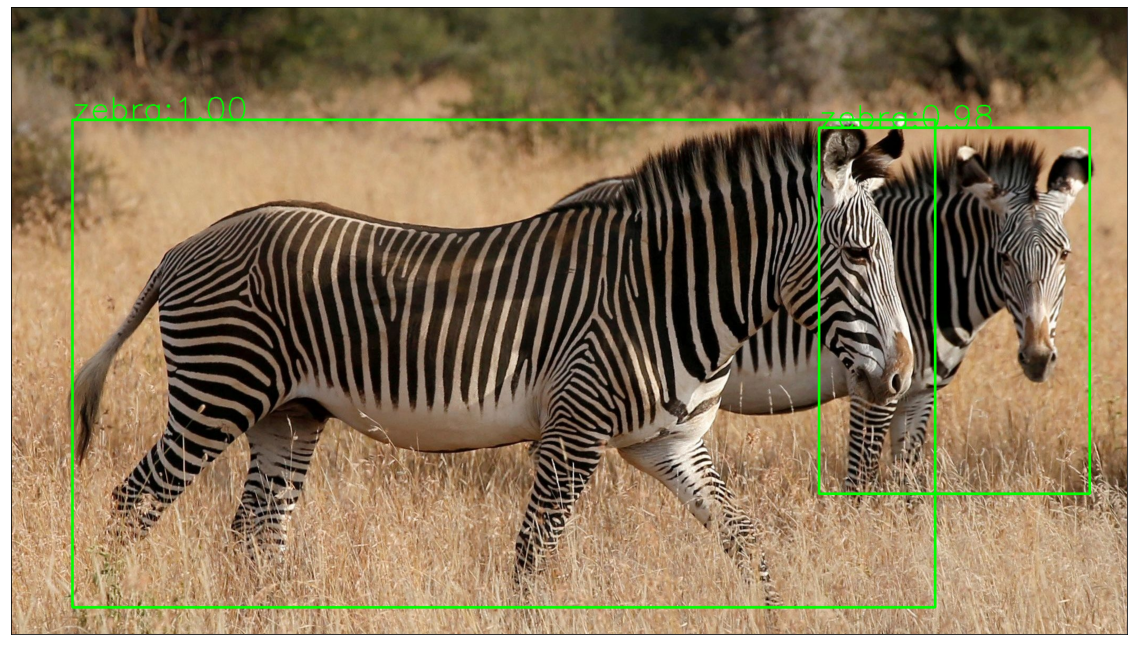

In [9]:
object_detection_api('./zebras.jpg', threshold=0.8, rect_th = 3, text_size=2, text_th=2)

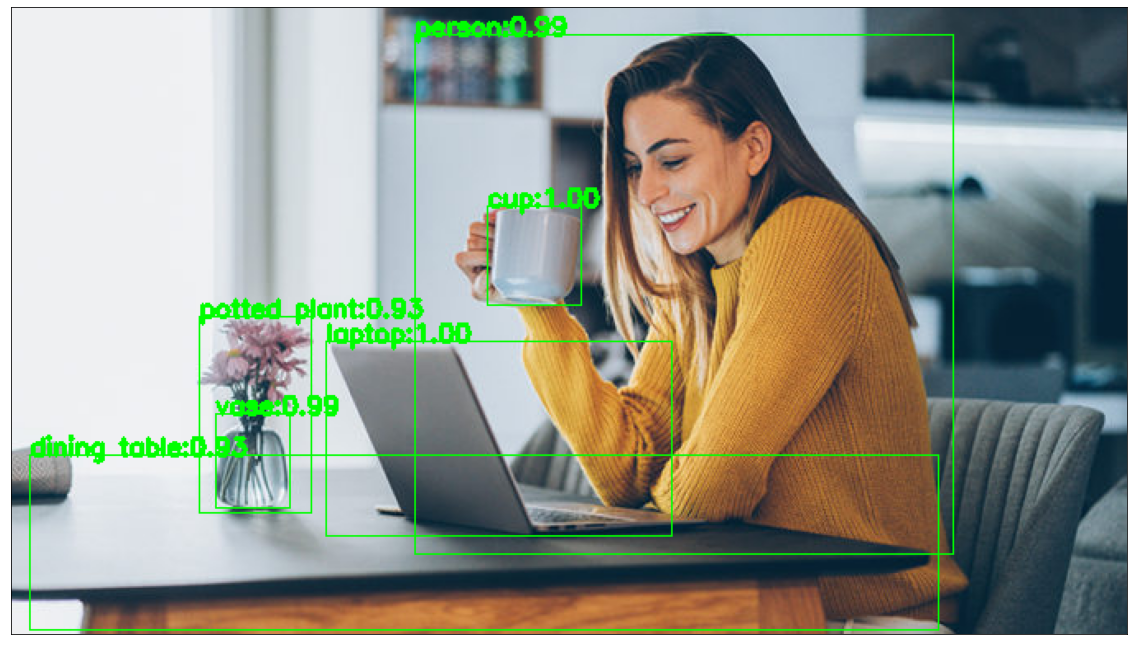

In [10]:
object_detection_api('./ofice.jpg', threshold=0.9, rect_th = 1, text_size=0.5, text_th=2)

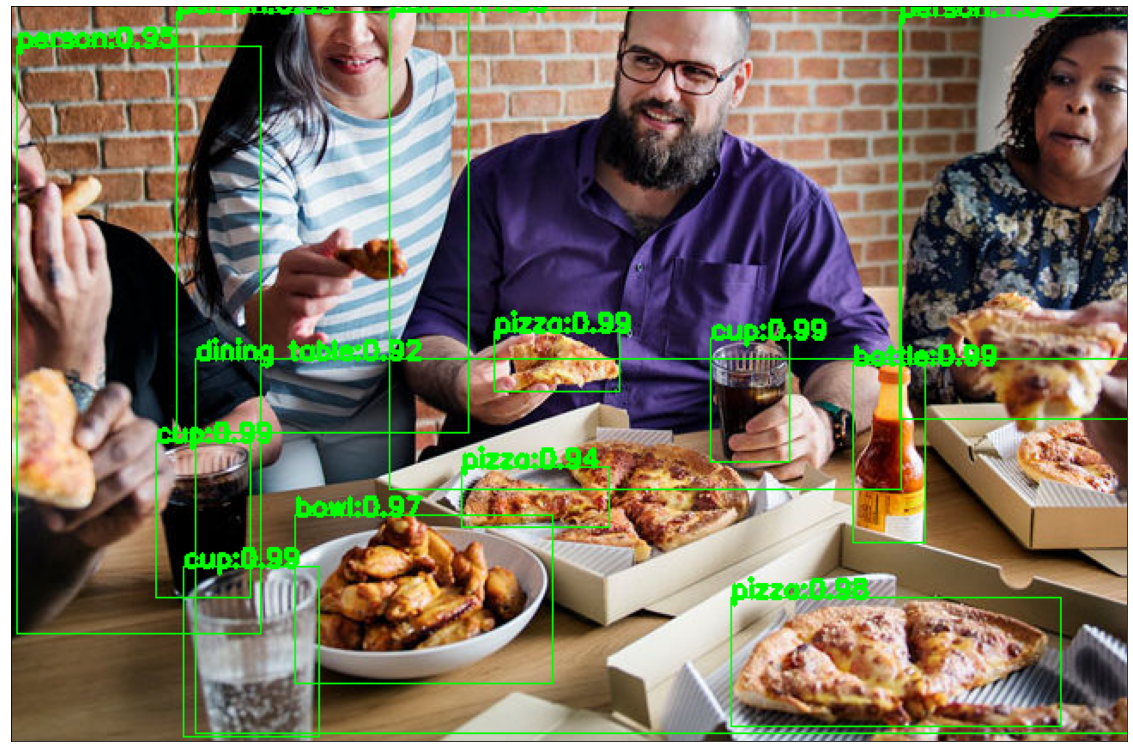

In [11]:
object_detection_api('./eating.jpg', threshold=0.9)

# Laboratorio Faster-RCNN parte 2

## Problema

Ya vimos como poder utilizar Faster-RCNN pre entrenado para detectar clases presentes en el dataset COCO en cualquier imagen. Pero que podriamos hacer si quisieramos poder detectar clases que no estan ahi? 

In [12]:
!wget https://raw.githubusercontent.com/bing0037/Raccoon_dataset/master/images/raccoon-1.jpg -O raccoon_example.jpg

--2021-11-05 16:21:36--  https://raw.githubusercontent.com/bing0037/Raccoon_dataset/master/images/raccoon-1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58076 (57K) [image/jpeg]
Saving to: ‘raccoon_example.jpg’

raccoon_example.jpg 100%[===================>]  56.71K  --.-KB/s    in 0.01s   

2021-11-05 16:21:37 (5.01 MB/s) - ‘raccoon_example.jpg’ saved [58076/58076]



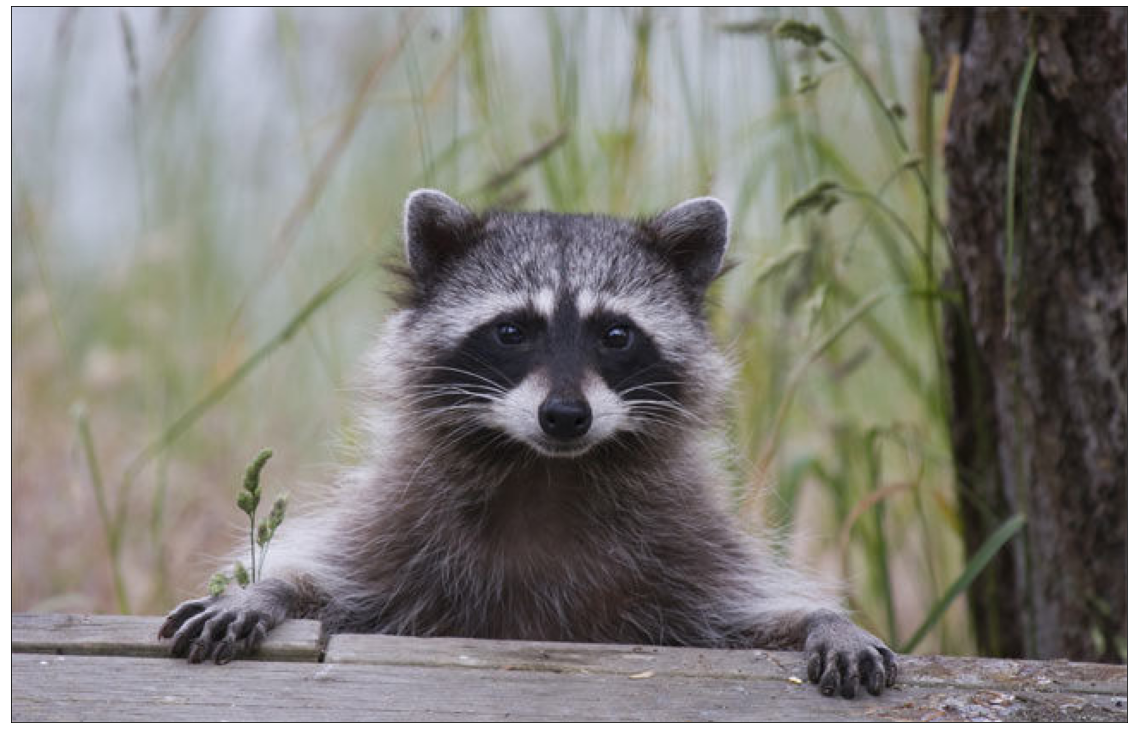

In [13]:
object_detection_api('./raccoon_example.jpg', threshold=0.9)

Para detectar objetos distintos a los de COCO basta con solo cambiar el clasificador del modelo. A esta tecnica se le llama Fine Tunning, y consiste en utilizar un modelo preentrenado para detectar (o clasificar) clases nuevas al mantener el backbone original y reemplazar solo la componente final del modelo, que corresponde al clasificador.

## Dataset

En https://github.com/bing0037/Raccoon_dataset podemos encontrar un dataset para la deteccion de mapaches. Este consiste en 200 imagenes (160 para entrenamiento y 40 para validaciones). Cada imagen es de un tamano distinto y poseen una cantidad diferente de mapaches.

Las anotaciones estan en un archivo .txt y tienen el siguiente formato:
img_path x_min,y_min,x_max_,y_max,label

Como este dataset es solo para detectar mapaches, label siempre toma el valor de 0

Antes de pasar a ver el modelo, debemos crear un data loader el cual nos entregue la imagen y las anotaciones en una forma que Faster RCNN pueda utilizar.

In [14]:
from torch.utils.data import Dataset

# Creamos nuestro data loader que usaremos para entrenar el modelo
class RaccoonDataLoader(Dataset):
  def __init__(self, data, device):
    self.img_list = []
    self.annotation_list = []
    self.device = device

    #Cargamos el .txt y extraemos todos los paths de las imagenes y las anotaciones para cada una
    file1 = open(data, 'r') 
    Lines = file1.readlines()  
    for line in Lines:
      tmp_line = line.strip()
      tmp_line = tmp_line.split()
      self.img_list.append(tmp_line[0])
      img_annotations = []
      for i in range(1, len(tmp_line)):
        tmp_annotation = tmp_line[i].split(',')
        tmp_annotation = [int(j) for j in tmp_annotation]
        img_annotations.append(tmp_annotation)
      self.annotation_list.append(img_annotations)
    file1.close() 

  def __getitem__(self, index):
    'Generates one sample of data'
    img_path = self.img_list[index]
    img = T.ToTensor()(Image.open(img_path).convert("RGB")) # Convertimos la imagen a un tensor 

    annotations_array = np.array(self.annotation_list[index]) #Convertimos las anotaciones a un numpy array
    boxes = annotations_array[:,:4] #De las anotaciones extraemos [x_min, y_min, x_max, y_max]
    labels = annotations_array[:,4] + 1 #Extraemos la clase de los objetos. Sumamos 1 porque la clase 0 siempre corresponde al fondo en Faster RCNN

    #El modulo de FasterRCNN de pytorch utiliza el siguiente formato de target para el entrenamiento
    target = {}
    target['boxes'] = torch.tensor(boxes, dtype = torch.float32)
    target['labels'] = torch.tensor(labels, dtype = torch.int64)
    target['image_id'] = torch.tensor([index])
    return img, target

  def __len__(self):
    return len(self.img_list)




In [15]:
#Descargamos el dataset
!git clone https://github.com/bing0037/Raccoon_dataset

Cloning into 'Raccoon_dataset'...
remote: Enumerating objects: 409, done.
remote: Total 409 (delta 0), reused 0 (delta 0), pack-reused 409
Receiving objects: 100% (409/409), 12.36 MiB | 26.54 MiB/s, done.
Resolving deltas: 100% (197/197), done.


In [16]:
#Para ver los archivos dentro de la carpeta podemos utilizar lo siguiente
!ls Raccoon_dataset

annotations  raccoon_classes.txt    raccoon_test.txt	    raccoon_train.txt
images	     raccoon_test_data.txt  raccoon_train_data.txt  ReadMe.md


In [17]:
def collate(batch):
    return tuple(zip(*batch))

In [18]:
#Instanciamos nuestros data loaders tanto para el entrenamiento como para la evaluacion
train_data = RaccoonDataLoader('Raccoon_dataset/raccoon_train_data.txt', device)
val_data = RaccoonDataLoader('Raccoon_dataset/raccoon_test_data.txt', device)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=collate)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=True, collate_fn=collate)

#Definimos cuantas clases vamos a tener
num_classes = 2  #Recordar que para Faster RCNN el fondo tambien es una clase, por lo que siempre tendremos una clase mas de las presentes en el dataset
Category = list(range(num_classes-1))

Para verificar que nuestro data loader este regresando lo que queremos, podemos pedirle que nos retorne la imagen y target para algun indice que nosotros queramos:

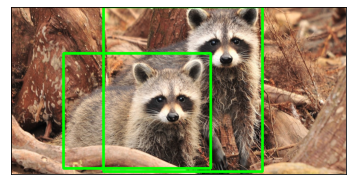

target: {'boxes': tensor([[ 98.,  88., 374., 303.],
        [173.,   1., 471., 309.]]), 'labels': tensor([1, 1]), 'image_id': tensor([13])}


In [19]:
img, target = train_data.__getitem__(13)
img = img.detach().cpu().numpy()
img = np.moveaxis(img, 0, 2)

img = (img * 255).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
boxes = target['boxes']
for i in range(len(target['boxes'])):
  cv2.rectangle(img, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]), color=(0, 255, 0), thickness=3) # Dibujamos un rectangulo de acuerdo a los BBs en el target

plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

print('target:', target)


Perfecto!

## Fine tunning

Con el dataloader listo, pasamos a instanciar nuestro modelo. Al igual que para la seccion anterior, utilizaremos la clase fasterrcnn_resnet50_fpn que nos ofrece pytorch, pero posteriormente le cambiaremos el clasificador por uno nuevo el cual este hecho para trabajar con nuestra nueva cantidad de clases.

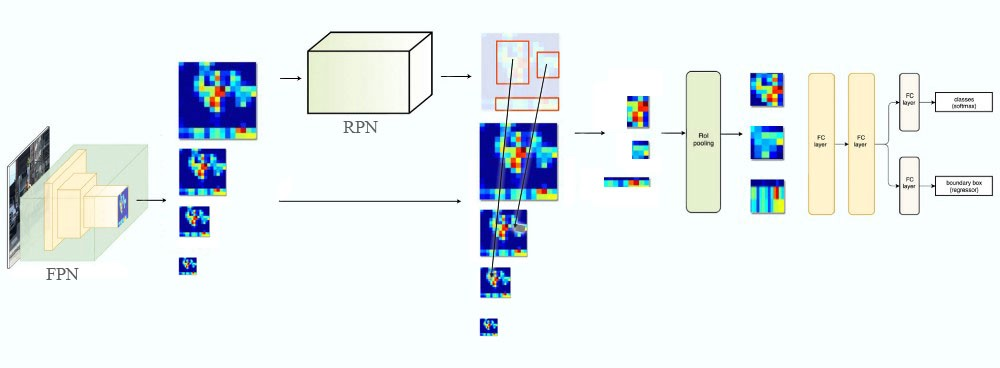

In [20]:
#Instanciamos Faster RCNN preentrenado
frcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)

#Obtenemos el tamano de entrada que tiene el clasificador de Faster RCNN 
in_features = frcnn_model.roi_heads.box_predictor.cls_score.in_features

#Definimos cuantas clases queremos que tenga nuestro clasificador (mapaches + background)
num_classes = 2

#Definimos que el predictor (o cabeza de Faster RCNN) sea una instancia nueva de un predictor de FastRCNN que reciba una entrada
# de tamano in_features y tenga una salida de tamano num_classes. Este reemplaza al anterior predictor de FastRCNN el cual recibia
# una entrada del mismo tamano, pero que tenia una salida del tamano de COCO
frcnn_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
frcnn_model.to(device) #Llevamos nuestro modelo al device (GPU)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Utilities

In [21]:
def iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / (bb1_area + bb2_area - intersection_area)
    return iou

In [22]:
def print_stats(stats, best_stats, epoch):
    print('True positives:')
    int2class = {0:'raccoon'}
    for category, value in stats['true_positives'].items():
        if stats['false_negatives'][category] + value > 0:
            percentage = value/(value+stats['false_negatives'][category])
            best_percentage, best_value, best_epoch = best_stats['true_positives'][category]

            if best_epoch == -1 or percentage > best_percentage:
                best_epoch = epoch
                best_percentage = percentage
                best_value = value
                best_stats['true_positives'][category] = percentage, value, epoch
                

            print('  {:14}{:<8.3f}{:>10}\tBest epoch: {:<3}{:<8.3f}{:>10}'.format(
                int2class[category], percentage, '({})'.format(value),
                best_epoch, best_percentage, '({})'.format(best_value),
            ))
    print()

    print('False negatives (hard positive):')
    for category, value in stats['false_negatives'].items():
        if stats['true_positives'][category] + value > 0:
            percentage = value/(value+stats['true_positives'][category])
            best_percentage, best_value, best_epoch = best_stats['false_negatives'][category]

            if best_epoch == -1 or percentage < best_percentage:
                best_epoch = epoch
                best_percentage = percentage
                best_value = value
                best_stats['false_negatives'][category] = percentage, value, epoch
            
            print('  {:14}{:<8.3f}{:>10}\tBest epoch: {:<3}{:<8.3f}{:>10}'.format(
                int2class[category], percentage, '({})'.format(value),
                best_epoch, best_percentage, '({})'.format(best_value),
            ))
    print()

    print('False positives (hard negative):')
    for category, value in stats['false_positives'].items():
        if stats['false_positives'][category] > 0:
            best_value, best_epoch = best_stats['false_positives'][category]
            if best_epoch == -1 or value < best_value:
                best_epoch = epoch
                best_percentage = percentage
                best_value = value
                best_stats['false_positives'][category] = value, epoch
            
            print('  {:14}{:<8}{:>10}\tBest epoch: {:<3}{:<8}{:>10}'.format(
                int2class[category], '', '({})'.format(value),
                best_epoch, '', '({})'.format(best_value),
            ))
    print()

In [23]:
def stats_2_metrics(stats):
    metrics = {'True positives': {},
               'False negatives': {},
               'False positives': {},
               'Precision': {},
               'Recall': {}}
    for category in Category:
        metrics['True positives'][category] = 0
        metrics['False negatives'][category] = 0
        metrics['False positives'][category] = 0
        metrics['Precision'][category] = 0
        metrics['Recall'][category] = 0
    for category, value in stats['true_positives'].items():
        if stats['false_negatives'][category] + value > 0:
            percentage = value/(value+stats['false_negatives'][category])
            metrics['True positives'][category] = percentage

    for category, value in stats['false_negatives'].items():
        if stats['true_positives'][category] + value > 0:
            percentage = value/(value+stats['true_positives'][category])
            metrics['False negatives'][category] = percentage

    for category, value in stats['false_positives'].items():
        if stats['false_positives'][category] > 0:
            metrics['False positives'][category] = value

    for category in Category:
        metrics['Recall'][category] = metrics['True positives'][category]
        metrics['Precision'][category] = stats['true_positives'][category] / (
            stats['true_positives'][category] + \
            stats['false_positives'][category] + 0.0000001) 
    return metrics

In [24]:
def filter_by_class_nms(detection):
    # NON MAXIMUM SUPRESION (by _label_)
    boxes = detection['boxes']; detection['boxes'] = torch.tensor([])
    labels = detection['labels']; detection['labels'] = torch.tensor([], dtype=labels.dtype)
    scores = detection['scores']; detection['scores'] = torch.tensor([])
    for category in Category:
        category_idxs = (labels == category + 1)
        relevant_boxes = boxes[category_idxs]
        relevant_scores = scores[category_idxs]
        keep_idxs = nms(relevant_boxes, relevant_scores, IOU_OVERLAP_THRESHOLD)
        detection['boxes'] = torch.cat([detection['boxes'], 
                                        relevant_boxes[keep_idxs],
                                       ])
        detection['scores'] = torch.cat([detection['scores'], 
                                        relevant_scores[keep_idxs],
                                       ])
        detection['labels'] = torch.cat([detection['labels'], 
                                        torch.full_like(keep_idxs, category+1),
                                       ])
    return detection

In [25]:
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [26]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    #print("train_one_epoch")
    model.train()
    print('Epoch: [{}]'.format(epoch))

    # using warmup
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    iterator = tqdm(data_loader)
    nans = 0
    moving_loss = 0.0
    
    for images, targets in iterator:
        images = [image.to(device) for image in images]
        images_rgb = [image[:3,:,:] for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images_rgb, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        if not math.isfinite(loss_value):
            nans += 1
        else:
            losses.backward()
            optimizer.step()
            
            if moving_loss == 0.0:
                moving_loss = loss_value
            else:
                moving_loss = moving_loss * 0.95 + loss_value * 0.05

        iterator.set_description(
            'Epoch: {}; Loss: {:.5f}; NANs: {}'.format(
                epoch, moving_loss, nans
            )
        )

        if lr_scheduler is not None:
            lr_scheduler.step()

        del images, images_rgb, losses
    return moving_loss

In [27]:
def eval_epoch(model, data_loader, device):
    print("Evaluating")
    model.eval()

    stats = {}
    stats['true_positives'] = {category:0 for category in Category}
    stats['false_positives'] = {category:0 for category in Category}
    stats['false_negatives'] = {category:0 for category in Category}

    iterator = tqdm(data_loader)
    for images, targets in iterator:
        images = (image.to(device) for image in images)
        images_rgb = [image[:3, :, :] for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #print('targets:',targets)
        batch_detections = model(images_rgb, targets)  # Dict{['boxes', 'labels', 'scores']}
        
        batch_detections = ({k: v.cpu() for k, v in det.items()} for det in batch_detections)
        # for category in bb_predictions:
        for batch_idx, detection in enumerate(batch_detections):
            image_idx = targets[batch_idx]['image_id']

            # NON MAXIMUM SUPRESION (by _label_)
            detection = filter_by_class_nms(detection)

            # FILTER BY MODEL CONFIDENCE
            detection_df = pd.DataFrame.from_dict(detection)
            relevant_dets = detection_df[
                detection_df['scores'] > SCORE_THRESHOLD]

            positives = []
            #img, target = data_loader.__getitem__(image_idx)
            my_img, my_targets = val_data.__getitem__(image_idx)
            #print(my_targets)
            bbs = my_targets['boxes']
            #bbs = targets[0]['boxes'] #Esto trae problemas
            bb_categories = my_targets['labels']
            for i in range(bbs.shape[0]):
                #bbs[i,0]
                gt_category = bb_categories[i] - 1
                gt_polygon = {
                    'x1': bbs[i,0],
                    'y1': bbs[i,1],
                    'x2': bbs[i,2],
                    'y2': bbs[i,3]
                }
                positive = False
                for (_, (box, pred_category,
                         score)) in relevant_dets.iterrows():
                    pred_category -= 1    # correct for index shift vs data
                    pred_polygon = {
                        'x1': box[0],
                        'y1': box[1],
                        'x2': box[2],
                        'y2': box[3],
                    }
                    #print('iou:',iou(gt_polygon, pred_polygon))
                    if iou(gt_polygon, pred_polygon) > IOU_POSITIVE_THRESHOLD:
                        if gt_category == pred_category:
                            positive = True
                            positives.append(pred_polygon)
                            break
                if positive:
                    stats['true_positives'][gt_category.item()] += 1
                else:
                    stats['false_negatives'][gt_category.item()] += 1
            for (_, (box, pred_category, score)) in relevant_dets.iterrows():
                pred_category -= 1    # correct for index shift vs data
                pred_polygon = {
                    'x1': box[0],
                    'y1': box[1],
                    'x2': box[2],
                    'y2': box[3],
                }
                if pred_polygon not in positives:
                    stats['false_positives'][pred_category] += 1
            
            del detection_df, relevant_dets, pred_category, score, bb_categories, bbs
        del images, images_rgb, targets, batch_detections, pred_polygon
    return stats

## Entrenamiento

In [28]:
def train_model(model, train_data_loader, val_data_loader, optimizer, lr_scheduler, device):
    file_name = 'frcnn_raccoon.model' #Con que nombre queremos guardar nuestro modelo
    MODELS_ROOT = '.' #En que carpeta queremos guardar el modelo
    save_path = os.path.join(MODELS_ROOT, file_name)
    best_precision = 0 #Como metrica para elegir el mejor modelo durante entrenamiento, usaremos la precision

    #Aqui se crean un diccionario para representar mejor el rendimiento durante la evaluacion, pero no es necesario para el entrenamiento
    best_stats = {}
    best_stats['true_positives'] = {category:(0, 0, -1) for category in Category}
    best_stats['false_negatives'] = {category:(None, None, -1) for category in Category}
    best_stats['false_positives'] = {category:(1, -1) for category in Category}

    epochs = 4 #Por cuantas epocas queremos entrenar nuestro modelo
    for epoch in range(epochs):
      train_loss = train_one_epoch(model, optimizer, train_data_loader, device, epoch) #Entrenamos durante una epoca
      lr_scheduler.step() #Modificamos el learning rate del optimizador acorde a cuantas epocas llevamos
      with torch.no_grad(): #En esta seccion evaluamos el modelo
        epoch_stats = eval_epoch(model, val_data_loader, device)
      print_stats(epoch_stats, best_stats, epoch) #Imprimimos en pantalla el rendimiento durante la evaluacion
      epoch_metrics = stats_2_metrics(epoch_stats) #Calculamos a partir del rendimiento en evaluacion distintas metricas que nos pueden interesar.
      print(epoch_metrics) #Mostramos las metricas en pantalla

      #Como arbitrariamente decidimos que queremos quedarnos con el modelo con la mejor precision, 
      # revisamos aqui si la precision de esta epoca supero a la anterior. De ser asi, sobreescribimos el modelo
      # para tener solamente el mejor guardado.
      if epoch_metrics['Precision'][0] > best_precision:
        best_precision = epoch_metrics['Precision'][0]
        # save training state
        with open(save_path, 'wb') as f:
            state = {
                "optimizer": optimizer.state_dict(), #Guardamos el estado del optimizador
                "model": model.state_dict(), #Los pesos actuales del modelo
                "scheduler": lr_scheduler.state_dict(), #El estado del scheduler del learning rate
                "epoch": epoch, #La epoca en la que estabamos
                "precision": epoch_metrics['Precision'][0], #La precision que tuve este modelo en validacion
            }
            torch.save(state, f) #Hacemos efectivo el guardado de todas las cosas anteriores

In [29]:
#En esta celda definimos los hyperparametros que se usaran para la validacion,
# definimos que optimizador utilizaremos para entrenar y lanzamos el entrenamiento.

SCORE_THRESHOLD = 0.5
IOU_OVERLAP_THRESHOLD = 0.5 #IOU significa intersection over union
IOU_POSITIVE_THRESHOLD = 0.7


params = [p for p in frcnn_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, 
    lr=0.005,
    momentum=0.9, 
    weight_decay=0.0005
)

# and a learning rate scheduler which decreases the learning rate by
# 0.7 every 2 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=2,
  gamma=0.8
)
train_model(frcnn_model, train_loader, val_loader, optimizer, lr_scheduler, device)

Epoch: [0]


Epoch: 0; Loss: 0.36010; NANs: 0: 100%|██████████| 40/40 [02:25<00:00,  3.64s/it]


Evaluating


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


True positives:
  raccoon       0.717         (33)	Best epoch: 0  0.717         (33)

False negatives (hard positive):
  raccoon       0.283         (13)	Best epoch: 0  0.283         (13)

False positives (hard negative):
  raccoon                    (100)	Best epoch: 0               (100)

{'True positives': {0: 0.717391304347826}, 'False negatives': {0: 0.2826086956521739}, 'False positives': {0: 100}, 'Precision': {0: 0.24812030056532308}, 'Recall': {0: 0.717391304347826}}
Epoch: [1]


Epoch: 1; Loss: 0.12538; NANs: 0: 100%|██████████| 40/40 [02:27<00:00,  3.69s/it]


Evaluating


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


True positives:
  raccoon       0.783         (36)	Best epoch: 1  0.783         (36)

False negatives (hard positive):
  raccoon       0.217         (10)	Best epoch: 1  0.217         (10)

False positives (hard negative):
  raccoon                     (32)	Best epoch: 1                (32)

{'True positives': {0: 0.782608695652174}, 'False negatives': {0: 0.21739130434782608}, 'False positives': {0: 32}, 'Precision': {0: 0.5294117639273357}, 'Recall': {0: 0.782608695652174}}
Epoch: [2]


Epoch: 2; Loss: 0.08902; NANs: 0: 100%|██████████| 40/40 [02:24<00:00,  3.62s/it]


Evaluating


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


True positives:
  raccoon       0.804         (37)	Best epoch: 2  0.804         (37)

False negatives (hard positive):
  raccoon       0.196          (9)	Best epoch: 2  0.196          (9)

False positives (hard negative):
  raccoon                     (21)	Best epoch: 2                (21)

{'True positives': {0: 0.8043478260869565}, 'False negatives': {0: 0.1956521739130435}, 'False positives': {0: 21}, 'Precision': {0: 0.6379310333828775}, 'Recall': {0: 0.8043478260869565}}
Epoch: [3]


Epoch: 3; Loss: 0.08088; NANs: 0: 100%|██████████| 40/40 [02:27<00:00,  3.68s/it]


Evaluating


100%|██████████| 10/10 [00:19<00:00,  1.97s/it]

True positives:
  raccoon       0.804         (37)	Best epoch: 2  0.804         (37)

False negatives (hard positive):
  raccoon       0.196          (9)	Best epoch: 2  0.196          (9)

False positives (hard negative):
  raccoon                     (21)	Best epoch: 2                (21)

{'True positives': {0: 0.8043478260869565}, 'False negatives': {0: 0.1956521739130435}, 'False positives': {0: 21}, 'Precision': {0: 0.6379310333828775}, 'Recall': {0: 0.8043478260869565}}


## Inferencia con el nuevo modelo

Ahora que tenemos nuestro modelo de Faster RCNN con el clasificador entrenado para detectar mapaches, podemos pasar a probar en inferencia si efectivamente es capaz de detectarlos.

Para esto, utilizaremos la misma API que definimos en la primera parte del laboratorio, pero debemos recordar modificar CATEGORY_NAMES, ya que ahora nuestras clases son distintas a las de COCO que usamos en el segmento anterior.

In [30]:
CATEGORY_NAMES = [
    '__background__', 'raccoon'
]

A continuacion, cargamos los pesos de la mejor epoca que tuvo el modelo de acuerdo a la precision en validacion, ya que de forma contraria, el modelo tendra los pesos que tuvo al finalizar la ultima epoca de entrenamiento, los cuales pueden no ser los mejores.

In [31]:
checkpoint = torch.load('frcnn_raccoon.model') #Cargamos el archivo de checkpoint que habiamos guardado
frcnn_model.load_state_dict(checkpoint['model']) #Cargamos los pesos del modelo guardado
frcnn_model.eval() #Ponemos el modelo en modo de evaluacion

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Probemos detectar mapaches en imagenes que el modelo nunca vio durante el entrenamiento. Para esto, tenemos ya a nuestra mano las imagenes del set de test o validacion.

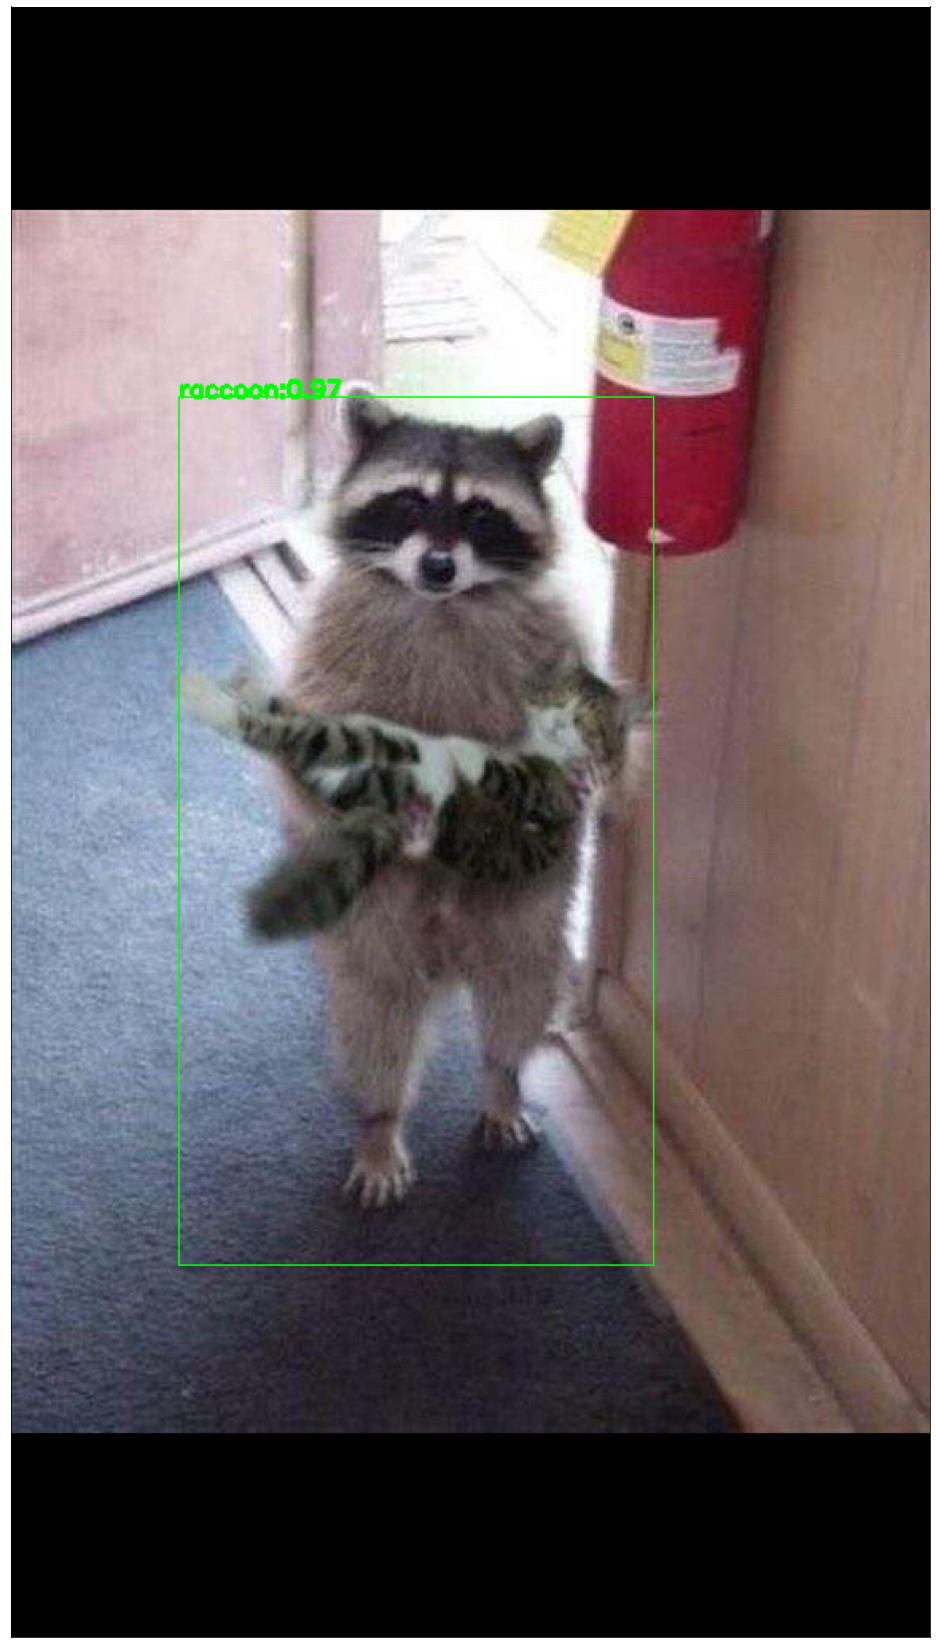

In [32]:
object_detection_api('Raccoon_dataset/images/raccoon-42.jpg', threshold=0.9)

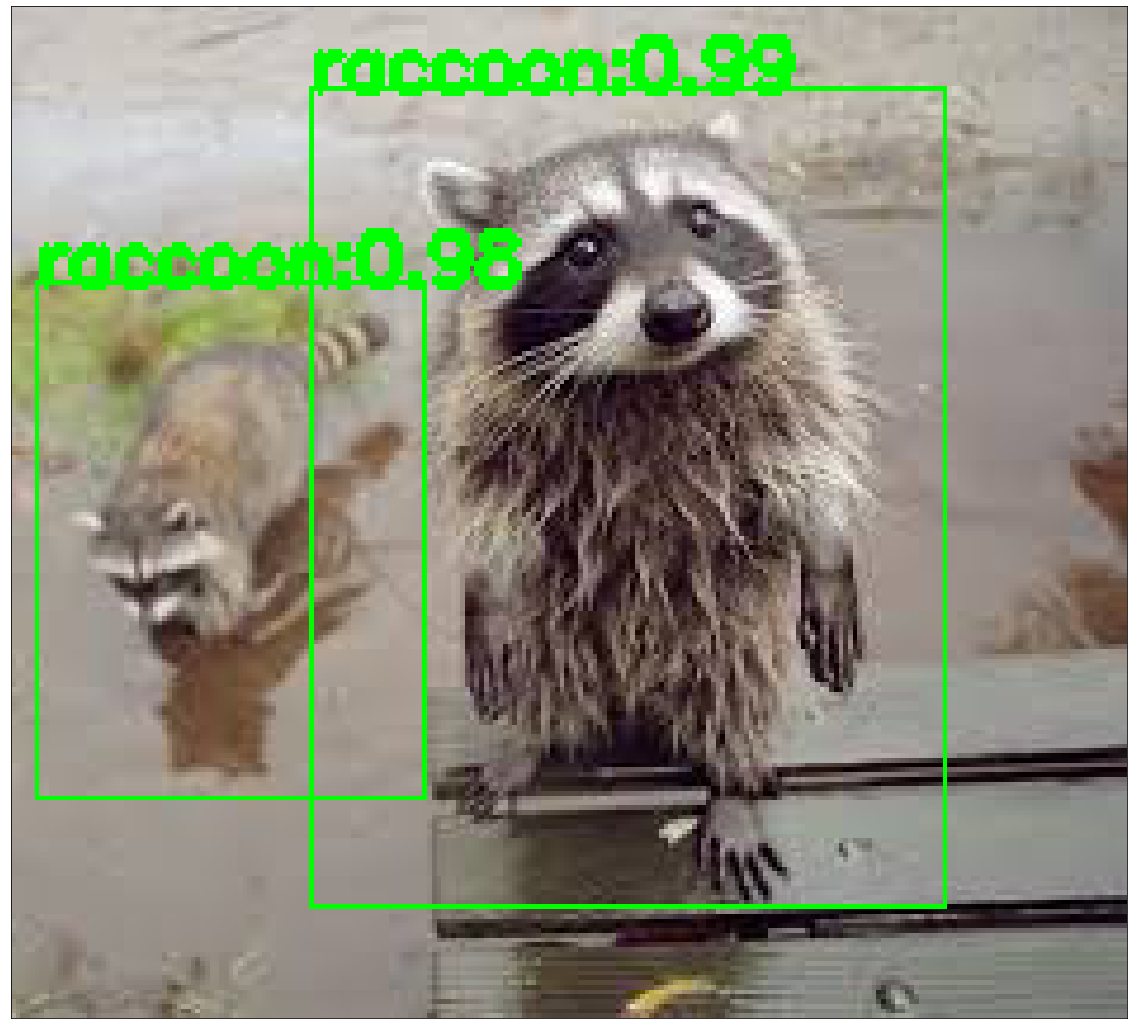

In [33]:
object_detection_api('Raccoon_dataset/images/raccoon-31.jpg', threshold=0.9)

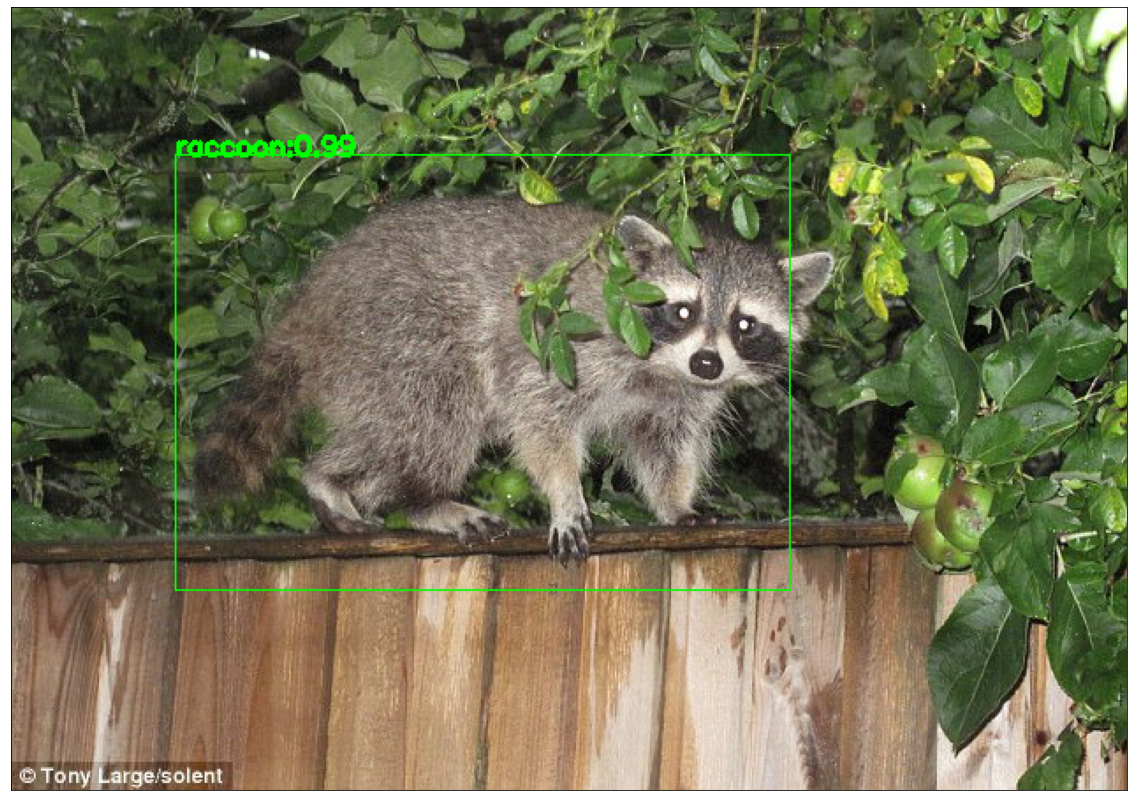

In [34]:
object_detection_api('Raccoon_dataset/images/raccoon-191.jpg', threshold=0.95)

# Tarea

Responder a las siguientes preguntas. Por favor recuerde ponerle su nombre al jupyter notebook al entregarlo.

1) Si quisiera utilizar su propio dataset con X clases distintas, que partes del codigo debiese modificar?

Respuesta: Las capas convolucionales se deben entrenar para detectar las nuevas categorias. Tambien se debe cambiar la "capa" de FastRCNNPredictor.

2) De acuerdo a lo visto en la clase y durante el laboratorio, Faster RCNN puede utilizar imagenes de cualquier tamano? En caso contrario, especifique de que tamano deben ser las imagenes que se le entregan al modelo.

Respuesta Las imagenes pueden tener cualquier tamaño, pero antes de entrar al modelo se deben pasar por una transformación (resize) para que cuadre con la capa de entrada de la CNN. El tamaño específico despues de la transformacion dependerá de cual CNN se use.